In [151]:
!pip install torch torch-geometric

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from ipywidgets import Text, Button, VBox, Dropdown, Output
from IPython.display import display

In [153]:
# Define nodes

# Node types
shapes = [
    "triangle",
    "triangle",
    "circle",
    "circle",
    "oval",
    "oval",
    "square",
    "square",
    "diamond",
    "diamond"
]

shape_to_onehot = {
    "triangle": [1,0,0,0,0],
    "circle":   [0,1,0,0,0],
    "oval":     [0,0,1,0,0],
    "square":   [0,0,0,1,0],
    "diamond":  [0,0,0,0,1]
}

x = torch.tensor([shape_to_onehot[s] for s in shapes], dtype=torch.float)


In [154]:
edge_list = [
    (0, 1),
    (0, 2),    # triangle → circle
    (1, 3),    # triangle → circle
    (2, 3),
    (4, 6),    # oval -> square
    (5, 7),    # oval -> square
    (4, 5),
    (2, 6),    # circle -> square
    (3, 7),    # circle -> square
    (6, 7),
    (6, 8),    # square -> diamond
    (7, 9),    # square -> diamond
    (8, 9)
]

edge_index = torch.tensor(edge_list, dtype=torch.long).t()

In [155]:
data = Data(x=x, edge_index=edge_index)
data


Data(x=[10, 5], edge_index=[2, 13])

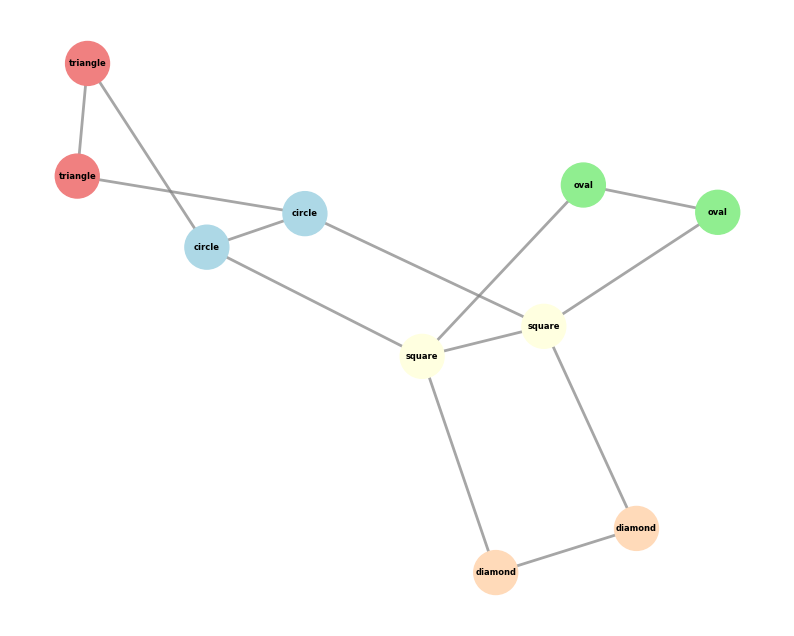

In [156]:
def visualize_graph(data, nodes, new_node, predicted_edges):
    G = nx.Graph()

    for i, shape in enumerate(nodes):
        G.add_node(i, label=shape)

    # Add edges
    edges = data.edge_index.t().tolist()
    G.add_edges_from(edges)

    if new_node is not None:
        G.add_node(len(nodes), label="new_node")
        nodes = nodes.copy()
        nodes.append("new_node")
        G.add_edges_from(predicted_edges)

    node_labels = nx.get_node_attributes(G, 'label')

    color_map = {
        "new_node": "lightgray",
        "triangle": "lightcoral",
        "circle": "lightblue",
        "oval": "lightgreen",
        "square": "lightyellow",
        "diamond": "peachpuff"
    }

    node_colors = [color_map[nodes[i]] for i in range(len(nodes))]

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray', alpha=0.7, width=2)
    if predicted_edges is not None:
      nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='red', alpha=0.7, width=2)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_weight='bold')

    plt.axis('off') # Hide axis
    plt.show()

visualize_graph(data, shapes, None, None)

In [157]:
class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim) # self
        self.conv2 = SAGEConv(hidden_dim, hidden_dim) # neighbors

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [158]:
def edge_score(z, edge_pairs):
    src, dst = edge_pairs
    return (z[src] * z[dst]).sum(dim=1)


In [159]:
model = GNN(in_dim=5, hidden_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Positive edges
pos_edges = edge_index

# Negative edges (wrong shape pairs)
neg_edges = torch.tensor([
    [0, 4, 1, 5],   # src node
    [6, 2, 7, 3]    # dest node
], dtype=torch.long)


In [160]:
for epoch in range(50):
    optimizer.zero_grad()

    z = model(data.x, data.edge_index)

    pos_score = edge_score(z, pos_edges) # learn the edge that exists
    neg_score = edge_score(z, neg_edges) # learn about edges that shouldn't exists

    pos_loss = F.binary_cross_entropy_with_logits(
        pos_score, torch.ones_like(pos_score)
    )
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_score, torch.zeros_like(neg_score)
    )

    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")


Epoch 0, Loss 1.7048
Epoch 10, Loss 0.6849
Epoch 20, Loss 0.0631
Epoch 30, Loss 0.0025
Epoch 40, Loss 0.0001


In [161]:
model.eval()

GNN(
  (conv1): SAGEConv(5, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
)

In [162]:
shape_options = ["triangle", "circle", "oval", "square", "diamond"]

shape_dropdown = Dropdown(
    options=shape_options,
    value=shape_options[0], # Default value
    description='Select Shape:',
    disabled=False,
)

submit_button = Button(description='Submit Selection')

output_area = Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        selected_shape = shape_dropdown.value
        new_node_features = torch.tensor([shape_to_onehot[selected_shape]], dtype=torch.float)
        x_new = torch.cat([data.x, new_node_features], dim=0)

        data_for_inference = Data(
            x=x_new,
            edge_index=data.edge_index
        )
        new_node_id = x_new.shape[0] - 1
        z = model(data_for_inference.x, data_for_inference.edge_index) # Get embeddings for all nodes including the new one

        scores = []
        for i in range(z.shape[0] - 1):  # exclude the new node itself
            score = torch.sigmoid(
                (z[new_node_id] * z[i]).sum()
            )
            scores.append((i, score.item()))

        scores.sort(key=lambda x: x[1], reverse=True)

        predicted_edges = []
        visualization_threshold = 0.9 # Only draw edges with probability > 0.9

        for idx, (node_id, prob) in enumerate(scores):
            if prob > visualization_threshold:
                predicted_edges.append((new_node_id, node_id))
        print(predicted_edges)
        visualize_graph(data_for_inference, shapes, new_node_id, predicted_edges)

submit_button.on_click(on_button_click)
display(VBox([shape_dropdown, submit_button, output_area]))